# Analyze Results - Plot Data Too Large for Built-in Visualizations

After running `scripts/5_compute.py` analyze your results here!

`scripts/5_compute.py` computed the energy values for all fragments generated in the `4_analysis-bigger-data.ipynb` notebook. We computed the energies for the reaction complex and each component individually (catalyst, lla (monomer), and MeOH (initiator)) so that we could generate a plot of the binding energy.

The key idea here is to notice that once our data outgrows the built-in visualizations of `qcio`, the structured data makes it easy to use plotting tools to make sense of our results.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"  # Renders as an iframe in Jupyter

from qcio import Structure, view, ProgramOutput, align, rmsd, constants

In [3]:
# Constants
DATA_DIR = Path("../data")
STRUCcT_DIR = DATA_DIR / "structures"
CALC_DIR = DATA_DIR / "calcs"

## Open Data and Compute the Binding Energy for Each Complex

In [4]:
def compute_binding_energy(complex, *frags):
    # Compute the binding energy of a complex from its fragements in kcal/mol
    indep_energy = 0
    for frag in frags:
        indep_energy += frag.results.energy

    return (complex.results.energy - indep_energy) * constants.HARTREE_TO_KCAL_PER_MOL

In [5]:
# Set the directory containing your fragment files.
FRAG_DIR = CALC_DIR / "frags"

# Group files by conformer index by splitting the filename.
conformer_groups = {}
for file in FRAG_DIR.glob("*-*-crest-energy.json"):
    # Expecting filename like "cat-32-crest-energy.json" or "complex-32-crest-energy.json"
    parts = file.name.split('-')  # e.g., ['cat', '32', 'crest', 'energy.json']
    prefix, idx = parts[0], parts[1]
    conformer_groups.setdefault(idx, {})[prefix] = file

conformer_idx = []
binding_energies = []
independent_energies = []

# List of required fragment identifiers.
required_fragments = ['cat', 'lla', 'meoh']

# Loop over each conformer group (assuming each group is complete).
for idx, group in conformer_groups.items():
    conformer_idx.append(idx)
    comp = ProgramOutput.open(group["complex"])
    frags = [ProgramOutput.open(group[frag]) for frag in required_fragments]
    # Compute the binding energy.
    be = compute_binding_energy(comp, *frags)
    binding_energies.append(be)
    # Compute the independent energy from fragments.
    ie = sum(frag.results.energy for frag in frags) * constants.HARTREE_TO_KCAL_PER_MOL
    independent_energies.append(ie)

# Convert results to numpy arrays.
binding_energies = np.array(binding_energies)
independent_energies = np.array(independent_energies)

### Make plots that help you to understand your underlying data

#### Matplotlib

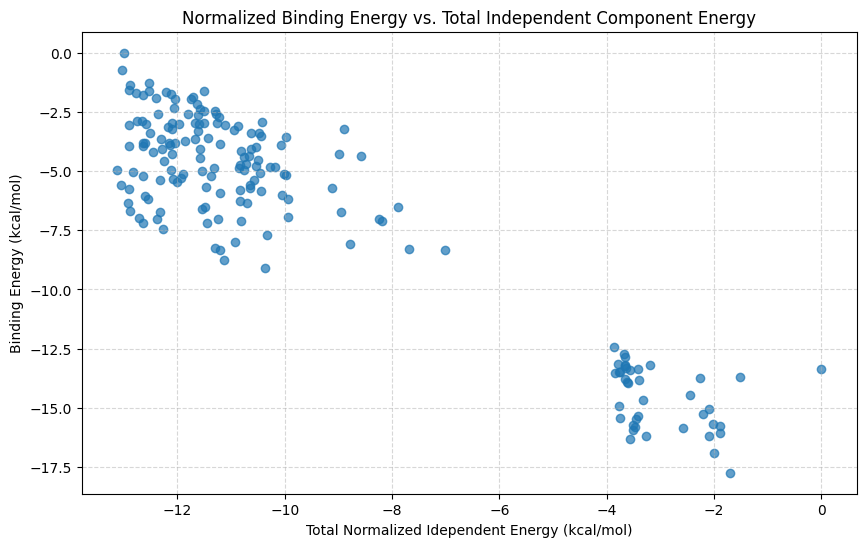

In [6]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(independent_energies - max(independent_energies), binding_energies - max(binding_energies), alpha=0.7)
plt.title("Normalized Binding Energy vs. Total Independent Component Energy")
plt.xlabel("Total Normalized Idependent Energy (kcal/mol)")
plt.ylabel("Binding Energy (kcal/mol)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### Plotly

In [8]:
# Create an interactive scatter plot
fig = px.scatter(
    x=independent_energies - max(independent_energies),
    y=binding_energies - max(binding_energies),
    labels={"x": "Normalized Independent Energy (kcal/mol)", "y": "Normalized Binding Energy (kcal/mol)"},
    title="Normalized Binding Energy vs. Total Independent Component Energy",
    hover_name=[f"Conformer Idx: {i}" for i in conformer_idx],  # Optional: Show conformer numbers on hover
)
fig.show()